## 1. Load Data

#### 1.1 Import images

In [3]:
from scripts.deepgtav.messages import frame2numpy
import numpy as np
import pickle
import bunch
import gzip
import os
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

# open the file
filepath = os.path.join(os.getcwd(), 'data')

filename = "E:\Backup\GTA V Dataset\dataset_4.pz"
pfile = gzip.open(filename, mode='rb')
new_picklefile_name = "I:\GTAV Dataset\dataset.pz"
new_picklefile = gzip.open(new_picklefile_name, mode='ab+')

In [4]:
count = 0
while True:
    try:
        count += 1
        var = pickle.load(pfile)
        pickle.dump(var, new_picklefile)
        if count%10000 == 0: print(count)
        if count>60000: break
    except EOFError: break

10000
20000
30000
40000
50000
60000


In [2]:
def apply_pca(image, dim=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.matrix(image)
    U, S, V = np.linalg.svd(image)
    reconst = np.matrix(U[:, :dim]) * np.diag(S[:dim]) * np.matrix(V[:dim, :])
    reconst = reconst[...,None]
    return reconst

[(150, 200, 1), (75, 100, 3)]
dict_keys(['direction', 'throttle', 'brake', 'steering', 'speed', 'yawRate', 'location', 'minimap', 'frame'])


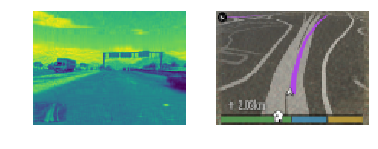

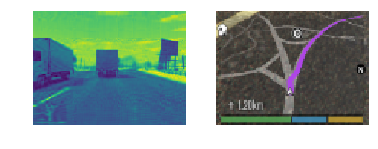

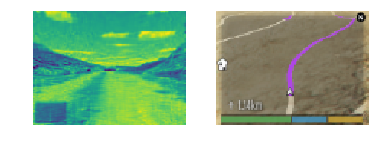

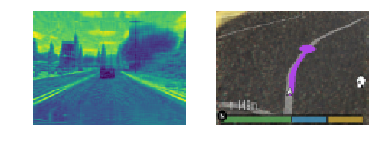

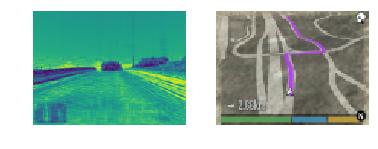

In [3]:
count = 0
no_of_channels = 3

frames_per_weather = 20000
reps_per_weather = 8
frames_per_rep = int(frames_per_weather/reps_per_weather)
image_size = (200, 150)     # required image size
minimap_size_req = (100, 75)     # required image size
minimap_size = (170, 110)  # current minimaps size
pca_dimension = 20

images = []
minimaps = []
outputs = []
speeds = []
yawRates = []

# find resize ratio
diff = []
diff.append(minimap_size[0] - image_size[0])
diff.append(minimap_size[1] - image_size[1])
ratio = 1- (np.min(diff) / minimap_size[np.argmin(diff)])

while True:
    try:
        
        # Load var from pickle
        var = pickle.load(pfile)
        
        # Skip first n frames
        count += 1
        # if count<3000: continue
            
        # Save image, minmap and steering
        image = var['frame']
        image = cv2.resize(image, image_size)
        image = apply_pca(image, pca_dimension)
        images.append(image)
        
        minimap = var['minimap']
        minimap = cv2.resize(minimap, minimap_size_req)
        minimap = minimap[:,:,:]
        minimaps.append(minimap)
        
        speeds.append(var['speed'])
        yawRates.append(var['yawRate'])
        outputs.append([var['steering'], var['throttle'], var['brake']])
        # outputs.append([var['steering']])
        
        # Display image
        if count % 1000 == 0:
            plt.subplot(121); plt.imshow(image[:,:,0]); plt.axis('off')
            plt.subplot(122); plt.imshow(minimap[:,:,::-1]); plt.axis('off')
            plt.show()
        
        if count == 1: print([image.shape, minimap.shape]); print(var.keys())
        if count>5000: break
            
            
    except EOFError: break
        

In [15]:
image.shape

(150, 200, 1)

In [5]:
y = np.array(outputs)[:,0]
print(y.shape)

(1495,)


In [6]:
pick_last_steering = 8
holder = np.zeros((y.shape[0], pick_last_steering))
gamma = 0.8
for i in range(holder.shape[0]):
    count = 0
    for j in range(i, i-pick_last_steering, -1):
        holder[i][count] = y[j-pick_last_steering]*(j>0)#*(gamma**(j-pick_last_steering))
        count += 1
print(holder.shape)

(1495, 8)


In [7]:
images = np.array(images)
minimaps = np.array(minimaps)
speeds = np.array(speeds)
yawRates = np.array(yawRates)
holder = np.array(holder)

# Get inputs and outputs
# x = {}
# x.images = images
# x.minimaps = minimaps
# x = np.concatenate((images, minimaps), axis=1)
# x = [images, minimaps, speeds, yawRates, holder]
x = [images, minimaps, holder, speeds, yawRates]

x_shape = [entity.shape for entity in x]
print('Dataset Shape: x: {} | y: {}'.format(x_shape, y.shape))

Dataset Shape: x: [(1495, 150, 200, 1), (1495, 75, 100, 3), (1495, 8), (1495,), (1495,)] | y: (1495,)


## 2. Preprocess Data

#### 2.1 Normalize images to [-1,1]

In [8]:
print([[np.min(entity), np.max(entity)] for entity in x])
if not isinstance(x, np.ndarray): 
    x_new = [(entity/255 - 0.5) * 2 for i, entity in enumerate(x) if i<2]
    if len(x)>=2: x_new = [*x_new, *x[2:]]
    x = x_new
[[np.min(entity), np.max(entity)] for entity in x]

[[-28.381750609724474, 284.1273622567752], [0, 255], [-1.0026761244002103, 1.0026761244002103], [0.0, 17.004619598388672], [-41.496834792977246, 106.02685014660935]]


[[-1.2226019655664664, 1.228449900053139],
 [-1.0, 1.0],
 [-1.0026761244002103, 1.0026761244002103],
 [0.0, 17.004619598388672],
 [-41.496834792977246, 106.02685014660935]]

In [9]:
print(np.min(y), np.max(y))
np.clip(y, -1, 1, out=y)
print(np.min(y), np.max(y))

-1.0026761244002103 1.0026761244002103
-1.0 1.0


#### 2.4 Split data for train and test

In [10]:
seed = 1
np.random.seed(seed)

recv = [None for i in range(2*len(x))]
from sklearn.model_selection import train_test_split
*recv, y_train, y_test = train_test_split(*x, y, test_size=0.2, random_state=np.random, shuffle=True)

x_train = recv[::2]
x_test = recv[1::2]

# print("Train Data | Test Data")
# x_train = [x0_train, x1_train]
# x_test = [x0_test, x1_test]
print(("{0:^10} | {1:^10}").format(x_train[0].shape[0], x_test[0].shape[0]))

   1196    |    299    


## 3. Build Model

#### 3.1 Import Keras and use NCHW mode

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.metrics import mae
from keras.initializers import RandomNormal
from keras.regularizers import Regularizer

from keras import backend
backend.set_image_dim_ordering('tf')

Using TensorFlow backend.


#### 3.2 Create reusable functions

In [12]:
h = x[0].shape[1]
w = x[0].shape[2]
#c = x[0].shape[3]
no_of_classes = y.shape[0]
#print(x.shape, y.shape)

def evaluate_model(model):
    print("\n\n")
    scores = model.evaluate(x_test, y_test)
    print("Accuracy: ", scores[1]*100, "%")
    return scores

#### 3.3 Create a baseline model

In [20]:
def baseline_model():
    
    # Level 1
    image = Input(shape=(h,w,c))
    conv_1_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)
    conv_1_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1_1)
    pool_1_1 = MaxPooling2D(pool_size=(2, 2))(conv_1_2)
    
    # Level 2
    conv_2_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1_1)
    conv_2_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2_1)
    pool_2_1 = MaxPooling2D(pool_size=(2, 2))(conv_2_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2_1)
    conv_3a_2 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)
    conv_3a_3 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1])
    dense_4_1 = Dense(4096, kernel_initializer='normal', activation='tanh')(concat_4_1)
    dense_4_2 = Dense(2048, kernel_initializer='normal', activation='tanh')(dense_4_1)
    dense_4_3 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_4_2)

    model = Model(inputs=[image, prev_steering], outputs=dense_4_3)
    model.compile(loss='mse', optimizer=Adam(lr=0.00001), metrics=[mae,'accuracy'])
    return model

In [21]:
def image_map_steering_concat_model(channels=3):

    h = 75          # height of the image
    w = 100         # width of the image
    c = channels    # no of channels
    
    # Level 1a
    image = Input(shape=(h,w,c))
    conv_1a_1 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)#64
    conv_1a_2 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1a_1)#64
    pool_1a_1 = MaxPooling2D(pool_size=(2, 2))(conv_1a_2)
    
    # Level 2a
    conv_2a_1 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1a_1)#128
    conv_2a_2 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2a_1)#128
    pool_2a_1 = MaxPooling2D(pool_size=(2, 2))(conv_2a_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2a_1)#256
    conv_3a_2 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)#256
    conv_3a_3 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)#256
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)
    
    # Level 1c
    maps = Input(shape=(h,w,c))
    conv_1c_1 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(maps)
    conv_1c_2 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1c_1)
    pool_1c_1 = MaxPooling2D(pool_size=(2, 2))(conv_1c_2)
    
    # Level 2c
    conv_2c_1 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1c_1)
    conv_2c_2 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2c_1)
    pool_2c_1 = MaxPooling2D(pool_size=(2, 2))(conv_2c_2)
    
    # Level 3c
    conv_3c_1 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2c_1)
    conv_3c_2 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_1)
    conv_3c_3 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_2)
    pool_3c_1 = MaxPooling2D(pool_size=(2, 2))(conv_3c_3)
    pool_3c_1f = Flatten()(pool_3c_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1, pool_3c_1f])
    dense_4_1 = Dense(100, kernel_initializer='normal', activation='tanh')(concat_4_1)#8192
    dense_4_2 = Dense(60, kernel_initializer='normal', activation='tanh')(dense_4_1)#4096
    dense_4_3 = Dense(40, kernel_initializer='normal', activation='tanh')(dense_4_2)#2048
    dense_4_4 = Dense(10, kernel_initializer='normal', activation='tanh')(dense_4_3)#512
    dense_4_5 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_4_4)#

    model = Model(inputs=[image, maps, prev_steering], outputs=dense_4_5)
    model.compile(loss='mse', optimizer=Adam(lr=0.00005), metrics=[mae,'accuracy'])
    return model

In [22]:
def image_map_steering_yaw_concat_model(channels=3):

    h = 75          # height of the image
    w = 100         # width of the image
    c = channels    # no of channels
    
    # Level 1a
    image = Input(shape=(h,w,c))
    conv_1a_1 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)#64
    conv_1a_2 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1a_1)#64
    pool_1a_1 = MaxPooling2D(pool_size=(2, 2))(conv_1a_2)
    
    # Level 2a
    conv_2a_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1a_1)#128
    conv_2a_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2a_1)#128
    pool_2a_1 = MaxPooling2D(pool_size=(2, 2))(conv_2a_2)
    
    # Level 3a
    #conv_3a_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2a_1)#256
    #conv_3a_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)#256
    #conv_3a_3 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)#256
    #pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_2a_1)
    
    c = 3
    
    # Level 1c
    maps = Input(shape=(h,w,c))
    conv_1c_1 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(maps)
    conv_1c_2 = Conv2D(32, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1c_1)
    pool_1c_1 = MaxPooling2D(pool_size=(2, 2))(conv_1c_2)
    
    # Level 2c
    conv_2c_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1c_1)
    conv_2c_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2c_1)
    pool_2c_1 = MaxPooling2D(pool_size=(2, 2))(conv_2c_2)
    
    # Level 3c
    #conv_3c_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2c_1)
    #conv_3c_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_1)
    #conv_3c_3 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_2)
    #pool_3c_1 = MaxPooling2D(pool_size=(2, 2))(conv_3c_3)
    pool_3c_1f = Flatten()(pool_2c_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1, pool_3c_1f])
    dense_4_1 = Dense(500, kernel_initializer='normal', activation='tanh')(concat_4_1)#8192
    dense_4_2 = Dense(250, kernel_initializer='normal', activation='tanh')(dense_4_1)#4096
    dense_4_3 = Dense(50, kernel_initializer='normal', activation='tanh')(dense_4_2)#2048
    dense_4_4 = Dense(10, kernel_initializer='normal', activation='tanh')(dense_4_3)#512
    
    #Level 5
    speed_input = Input(shape=(1,))
    yaw_input = Input(shape=(1,))
    concat_5_1 = concatenate([dense_4_4, speed_input, yaw_input])
    dense_5_1 = Dense(5, kernel_initializer='normal', activation='tanh')(concat_5_1)
    dense_5_2 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_5_1)
    
    model = Model(inputs=[image, maps, prev_steering, speed_input, yaw_input], outputs=dense_5_2)
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=[mae,'accuracy'])
    return model

In [13]:
from keras import regularizers

def image_map_steering_yaw_concat_regularised_model(channels=3):

    h1 = 150         # height of the image
    w1 = 200         # width of the image
    c1 = 1
    
    # Level 1a
    image = Input(shape=(h1,w1,c1))
    conv_1a_1 = Conv2D(32, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh', input_shape=(h1,w1,c1))(image)#64
    conv_1a_2 = Conv2D(32, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(conv_1a_1)#64
    pool_1a_1 = MaxPooling2D(pool_size=(2, 2))(conv_1a_2)
    
    # Level 2a
    conv_2a_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(pool_1a_1)#128
    conv_2a_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(conv_2a_1)#128
    pool_2a_1 = MaxPooling2D(pool_size=(2, 2))(conv_2a_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2a_1)#256
    conv_3a_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)#256
    conv_3a_3 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)#256
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)
    
    h2 = 75          # height of the image
    w2 = 100         # width of the image
    c2 = 3
    
    # Level 1c
    maps = Input(shape=(h2,w2,c2))
    conv_1c_1 = Conv2D(32, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh', input_shape=(h2,w2,c2))(maps)
    conv_1c_2 = Conv2D(32, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(conv_1c_1)
    pool_1c_1 = MaxPooling2D(pool_size=(2, 2))(conv_1c_2)
    
    # Level 2c
    conv_2c_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(pool_1c_1)
    conv_2c_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(conv_2c_1)
    pool_2c_1 = MaxPooling2D(pool_size=(2, 2))(conv_2c_2)
    
    # Level 3c
    conv_3c_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2c_1)
    conv_3c_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_1)
    conv_3c_3 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_2)
    pool_3c_1 = MaxPooling2D(pool_size=(2, 2))(conv_3c_3)
    pool_3c_1f = Flatten()(pool_3c_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1, pool_3c_1f])
    dense_4_1 = Dense(500, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(concat_4_1)#8192
    dense_4_2 = Dense(250, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(dense_4_1)#4096
    dense_4_3 = Dense(50, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(dense_4_2)#2048
    dense_4_4 = Dense(10, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh')(dense_4_3)#512
    
    #Level 5
    speed_input = Input(shape=(1,))
    yaw_input = Input(shape=(1,))
    concat_5_1 = concatenate([dense_4_4, speed_input, yaw_input])
    dense_5_1 = Dense(5, kernel_initializer='normal', activation='tanh')(concat_5_1)
    dense_5_2 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_5_1)
    
    model = Model(inputs=[image, maps, prev_steering, speed_input, yaw_input], outputs=dense_5_2)
    model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=[mae,'accuracy'])
    return model

In [14]:
#model = image_map_steering_concat_model(channels=3)#baseline_model()
model = image_map_steering_yaw_concat_regularised_model(channels=1)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 200, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 148, 198, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 73, 98, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
print(len(x_train))

5


In [16]:
model.fit(x_train, y_train, validation_split=0.1, epochs=25, batch_size=25)
evaluate_model(model)

Train on 1076 samples, validate on 120 samples
Epoch 1/25
1076/1076 [==============================] - 167s 155ms/step - loss: 276.4574 - mean_absolute_error: 0.0815 - acc: 0.0019 - val_loss: 115.8145 - val_mean_absolute_error: 0.0814 - val_acc: 0.0083
Epoch 2/25
1076/1076 [==============================] - 106s 98ms/step - loss: 62.3929 - mean_absolute_error: 0.0746 - acc: 0.0019 - val_loss: 27.0034 - val_mean_absolute_error: 0.0796 - val_acc: 0.0083
Epoch 3/25
1076/1076 [==============================] - 106s 99ms/step - loss: 14.8970 - mean_absolute_error: 0.0724 - acc: 0.0019 - val_loss: 6.6738 - val_mean_absolute_error: 0.0760 - val_acc: 0.0083
Epoch 4/25
1076/1076 [==============================] - 107s 99ms/step - loss: 3.7409 - mean_absolute_error: 0.0725 - acc: 0.0019 - val_loss: 1.7238 - val_mean_absolute_error: 0.0764 - val_acc: 0.0083
Epoch 5/25
1076/1076 [==============================] - 107s 99ms/step - loss: 0.9885 - mean_absolute_error: 0.0728 - acc: 0.0019 - val_loss:

[0.03673081919624872, 0.06899783719816933, 0.020066889632107024]

In [17]:
model.predict(x_train[:10])

array([[ 0.00827343],
       [-0.00771354],
       [ 0.01858158],
       ...,
       [-0.68125415],
       [-0.00284388],
       [ 0.05209197]], dtype=float32)

In [18]:
y_train[:10]

array([-0.00615605, -0.0213119 ,  0.00550172, -0.15797681, -0.01075887,
       -1.        ,  0.08035171,  0.00605054,  0.0898245 , -0.00978698])

## 4. Saving and loading model architecture and weights

#### 4.1 Define reusable functions

In [3]:
import h5py
from keras.models import model_from_json
from keras.models import load_model
import os

path_models = os.path.join(os.getcwd(), 'models')
valid_model_files = [".h5", ".json"]
weights_suffix = '_weights.h5'
architecture_suffix = '_architecture.json'

In [4]:
def get_last_file_number(path):
    numbers = [-1]
    for file in os.listdir(path):
        filename = os.path.splitext(file)[0]
        ext = os.path.splitext(file)[1]
        if ext.lower() not in valid_model_files: continue
        if filename.startswith('model_'): 
            numbers.append(int(''.join(list(filter(str.isdigit, filename)))))
    counter = max(numbers)
    return counter

#### 4.2 Save current model

In [ ]:
counter = 0
if not os.path.isdir(path_models): os.makedirs(path_models)
else: counter = get_last_file_number(path_models) + 1

model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + weights_suffix
with open(model_arch_file, 'w+') as json_file:
    json_file.write(model.to_json(indent=4))
# model.save_weights(model_weights_file)

model.save(path_models + '\\' + model_name + '.h5')

print("Saving files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

#### 4.3 Load model from file

In [1]:
counter = get_last_file_number(path_models)
    
model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + architecture_suffix

print("Loading files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

if not os.path.isfile(model_arch_file):
    print('Could not find', model_arch_file)
elif not os.path.isfile(model_weights_file):
    print('Could not find', model_weights_file)
else:
    # with open(model_arch_file, 'r') as json_file:
        # model_loaded = model_from_json(json_file.read())
    # model_loaded.load_weights(model_weights_file)
    model_loaded = load_model(path_models + '\\' + model_name + '.h5')

NameError: name 'get_last_file_number' is not defined

In [28]:
from keras import backend
dir(model_loaded.optimizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'amsgrad',
 'beta_1',
 'beta_2',
 'decay',
 'epsilon',
 'from_config',
 'get_config',
 'get_gradients',
 'get_updates',
 'get_weights',
 'initial_decay',
 'iterations',
 'lr',
 'set_weights',
 'updates',
 'weights']

In [81]:
print('____________________________________________\n')
print('{:>20} : {}'.format('Optimer', type(model_loaded.optimizer).__name__))
print('____________________________________________\n')
print('{:>20} : {}'.format('lr', backend.get_value(model_loaded.optimizer.lr)))
print('{:>20} : {}'.format('beta_1', backend.get_value(model_loaded.optimizer.beta_1)))
print('{:>20} : {}'.format('beta_2', backend.get_value(model_loaded.optimizer.beta_2)))
print('{:>20} : {}'.format('decay', backend.get_value(model_loaded.optimizer.decay)))
print('{:>20} : {}'.format('amsgrad', model_loaded.optimizer.amsgrad))
print('{:>20} : {}'.format('epsilon', model_loaded.optimizer.epsilon))
print('{:>20} : {}'.format('initial_decay', model_loaded.optimizer.initial_decay))
print('____________________________________________\n')

____________________________________________

             Optimer : Adam
____________________________________________

                  lr : 9.999999747378752e-06
              beta_1 : 0.8999999761581421
              beta_2 : 0.9990000128746033
               decay : 0.0
             amsgrad : False
             epsilon : 1e-07
       initial_decay : 0.0
____________________________________________



In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 98, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 46, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 44, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 22, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 20, 256)       295168    
__________

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.metrics import mae
from keras.initializers import RandomNormal

from keras import backend
backend.set_image_dim_ordering('tf')

def loss(y_true, y_pred): return backend.sum(backend.abs(y_true - y_pred))
def accuracy(y_true, y_pred): return 1 - backend.mean(backend.minimum(1.0,((backend.abs(y_true - y_pred))*10)))

def tanh_model(channels=1):
    
    h = 75          # height of the image
    w = 100         # width of the image
    c = channels    # no of channels

    model = Sequential()
        
    model.add(Conv2D(32, (7, 7), kernel_initializer='normal', activation='tanh', input_shape=(h, w, c)))
    model.add(Conv2D(32, (7, 7), kernel_initializer='normal', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (5, 5), kernel_initializer='normal', activation='tanh'))
    model.add(Conv2D(64, (5, 5), kernel_initializer='normal', activation='tanh'))
    model.add(Conv2D(64, (5, 5), kernel_initializer='normal', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3, 3), kernel_initializer='normal', activation='tanh'))
    model.add(Conv2D(128, (3, 3), kernel_initializer='normal', activation='tanh'))
    model.add(Conv2D(128, (3, 3), kernel_initializer='normal', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(2048, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1024, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(128, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=Adam(0.001), metrics=['mae',accuracy])
    return model

Using TensorFlow backend.


In [4]:
model = tanh_model()

In [5]:
def print_optimizer(model):
	print()
	print('{:>20} : {}'.format('Optimizer', type(model.optimizer).__name__))
	print('_________________________________________________________________\n')
	print('{:>20} : {:7.6f}'.format('lr', backend.get_value(model.optimizer.lr)))
	print('{:>20} : {:7.6f}'.format('beta_1', backend.get_value(model.optimizer.beta_1)))
	print('{:>20} : {:7.6f}'.format('beta_2', backend.get_value(model.optimizer.beta_2)))
	print('{:>20} : {}'.format('decay', backend.get_value(model.optimizer.decay)))
	print('{:>20} : {}'.format('amsgrad', model.optimizer.amsgrad))
	print('{:>20} : {}'.format('epsilon', model.optimizer.epsilon))
	print('{:>20} : {}'.format('initial_decay', model.optimizer.initial_decay))
	print('_________________________________________________________________\n')

def print_metrics(model):
	print('{:>20} : {}'.format('Loss Function', model.loss if not callable(model.loss) else model.loss.__name__))
	print('_________________________________________________________________\n')
	for i,metric in enumerate(model.metrics):
		print('{:>18} {} : {}'.format('Metric',i, metric if not callable(metric) else metric.__name__))
	print('_________________________________________________________________\n')

In [4]:
model.summary()
print_optimizer(model)
print_metrics(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 69, 94, 32)        1600      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 88, 32)        50208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 44, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 40, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 36, 64)        102464    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 16, 64)         0         
__________

In [136]:
dir(loss)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [148]:
loss.__name__ = "Sum of Absolute Errors"

In [143]:
loss.__name__

'Sum of Absolute Errors'

In [146]:
def loss(y_true, y_pred): 
    self.__name__ = "Sum of Absolute Errors"
    return backend.sum(backend.abs(y_true - y_pred))

In [149]:
loss.__name__

'Sum of Absolute Errors'

In [10]:
model.layers[0].output

<tf.Tensor 'conv2d_9/Tanh:0' shape=(?, 69, 94, 32) dtype=float32>